In [1]:
import math
import numpy as np
from numpy import zeros
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
from prettytable import PrettyTable
import pandas_market_calendars as mcal
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Introduction

In this project we aim to predict the daily price of stocks for various publicly traded companies.

We employ a fully-connected feedforward neural network that uses 3 historical data values as inputs : the minimum price seen, maximum price seen, and average closing price across a 'sliding window' of time preceding the day that is to be predicted for.

The end-of-trading-day stock prices for the entirety of the years 2012 through 2019 (inclusive) are used as training data. The prices from the start of 2020 to the present (May 2021) are used as unseen testing data.

We create our network and then compare its performance across a variety of alterations: different activation function choices, different values for network parameters, and different lengths of time window for our inputs.

Finally, we run a small trading simulation using our test data to see whether our neural network predictions would be useful for generating revenue.

# Methodology

## Define Activation Functions

At the end of each 'neuron' node of the neural network, the function calculates the dot product of the vector of its inputs and vector of its weights. Then, it feeds the output to the ***activation function*** in a process similar to logistic regression. The gradient of the activation function is used for updating the weights during backpropogation, so the choice of function here will have a large effect on the network's training behavior and performance.

In this network, we will use the sigmoid function (a smoothed version of the Heaviside step function), the hyperbolic tangent function and the rectified linear unit (ReLU) function (sometimes simply called the rectifier function).

Sigmoid takes a real value as input and outputs another value between 0 and 1. It’s easy to work with and has all the nice properties of activation functions: it’s non-linear, continuously differentiable, monotonic, and has a fixed output range.<br>
<cite>https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html</cite>

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def deltaSigmoid(y):
    return y * (1 - y)

The tanh activation function is a non-linear function which squashes a real-valued number to the range [-1, 1]. Like the sigmoid neuron, its activations saturate, but unlike the sigmoid neuron its output is zero-centered. Therefore, in practice the tanh non-linearity is always preferred to the sigmoid nonlinearity. Also note that the tanh neuron is simply a scaled sigmoid neuron, in particular the following holds: $ {tanh(x)=2σ(2x)−1.} $
<cite>https://www.sciencedirect.com/topics/computer-science/sigmoid-function</cite>

In [3]:
def tanh(x):
    return math.tanh(x)

def deltaTanh(y):
    return 1.0 - y ** 2

The ReLU (Rectified Linear Unit) activation function is piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.<br>
<cite>https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/<cite>

In [4]:
def ReLU(x):
    return np.maximum(x, 0)

def deltaReLU(y):
    return y > 0

## Define Neural Network

The following code builds our **neural network**. We will use a network with 3 input nodes representing the minimum, maximum and average price seen across a trailing window of time (60 days initially) for each trading day. Our 'hidden' layer consists initially of 2 'neuron' nodes for this network. The 'forward' function runs the inputs through the fully-connected neural network in the forward direction, holding its model weights as fixed, generating a prediction for the stock price 1 day forward. Each node in the hidden and output layers calculates a dot product of its inputs and weights, then applies an activation function (sigmoid, hyperbolic tangent, or rectifier) to decide how the 'neuron' is 'firing' (to use the biological analogy). At the end the output has some error to the actual stock prices in the training data for the corresponding day. We use the gradient of the activation function to update the weights of the output in a direction that will lower this error ('**gradient descent**'), going backwards through the network from the output layer weights first, to the hidden layer weights last ('**backpropagation**'). Thus, we improve our model iteratively. 

Neural Network for Stock Prediction.jpeg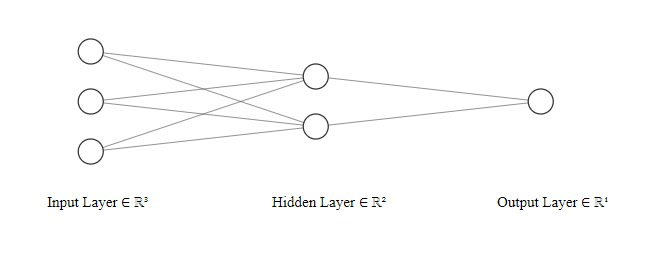

In [5]:
'''Build neural network'''
class network:
    def __init__(self, architecture = [3, 2, 1], iters = 1000, lrate = 0.1, activate_function='tanh'):
        # Initialize inputs as well as bias
        self.inputs = architecture[0] + 1

        # Initialize hidden units
        self.hidden = architecture[1]

        # Initialize output units
        self.outputs = architecture[2]
        
        # Initialize activation function
        self.activate_fun = activate_function
        
        # Initialize activation for input nodes
        self.input_activations = [1.0] * self.inputs

        # Initialize activation for hidden units
        self.hidden_activations = [1.0] * self.hidden

        # Initialize activation for output units
        self.outputs_activations = [1.0] * self.outputs

        # Initialize weight matrix between inputs and hidden units
        self.input_weights = random.rand(self.inputs, self.hidden)

        # Initialize weight matrix between hidden units and outputs
        self.output_weights = random.rand(self.hidden, self.outputs)

        # Learning rate 
        self.lr = lrate

        # Iterations epochs to train network
        self.epochs = iters

    def forward(self, inputs):
        # Compute activation for all inputs except bias
        for input in range(self.inputs - 1):
            self.input_activations[input] = inputs[input]

        # Compute activation for all hidden units
        for hidden in range(self.hidden):
            sum = 0.0
            for input in range(self.inputs):
                sum += self.input_activations[input] * self.input_weights[input][hidden]
            if self.activate_fun == 'tanh':
                self.hidden_activations[hidden] = tanh(sum)
            elif self.activate_fun == 'sigmoid':
                self.hidden_activations[hidden] = sigmoid(sum)
            elif self.activate_fun == 'ReLU':
                self.hidden_activations[hidden] = ReLU(sum)

        # Compute activation for all output units
        for output in range(self.outputs):
            sum = 0.0
            for hidden in range(self.hidden):
                sum += self.hidden_activations[hidden] * self.output_weights[hidden][output]
            if self.activate_fun == 'tanh':
                self.outputs_activations[output] = tanh(sum)
            elif self.activate_fun == 'sigmoid':
                self.outputs_activations[output] = sigmoid(sum)
            elif self.activate_fun == 'ReLU':
                self.outputs_activations[output] = ReLU(sum)

        return self.outputs_activations

    def backpropagate(self, targets):
        # Compute error at output units
        output_deltas = [0.0] * self.outputs
        for output in range(self.outputs):
            error = targets[output] - self.outputs_activations[output]
            if self.activate_fun == 'tanh':
                output_deltas[output] = deltaTanh(self.outputs_activations[output]) * error
            elif self.activate_fun == 'sigmoid':
                output_deltas[output] = deltaSigmoid(self.outputs_activations[output]) * error
            elif self.activate_fun == 'ReLU':
                output_deltas[output] = deltaReLU(self.outputs_activations[output]) * error

        # Compute error at hidden units
        hidden_deltas = [0.0] * self.hidden
        for hidden in range(self.hidden):
            error = 0.0
            for output in range(self.outputs):
                error += output_deltas[output] * self.output_weights[hidden][output]
            if self.activate_fun == 'tanh':
                hidden_deltas[hidden] = deltaTanh(self.hidden_activations[hidden]) * error
            if self.activate_fun == 'sigmoid':
                hidden_deltas[hidden] = deltaSigmoid(self.hidden_activations[hidden]) * error
            if self.activate_fun == 'ReLU':
                hidden_deltas[hidden] = deltaReLU(self.hidden_activations[hidden]) * error

        # Update output unit weights
        for hidden in range(self.hidden):
            for output in range(self.outputs):
                update = output_deltas[output] * self.hidden_activations[hidden]
                self.output_weights[hidden][output] = self.output_weights[hidden][output] + self.lr * update

        # Update input unit weights
        for input in range(self.inputs):
            for hidden in range(self.hidden):
                update = hidden_deltas[hidden] * self.input_activations[input]
                self.input_weights[input][hidden] = self.input_weights[input][hidden] + self.lr * update

        # Compute total error
        error = 0.0
        for target in range(len(targets)):
            # Using MSE method to calculate loss
            error += 0.5 * (targets[target] - self.outputs_activations[target]) ** 2
        return error

    def test(self, pattern):
        # for pattern in patterns:
        self.forward(pattern)
        return self.forward(pattern)[0]


    def train(self, patterns, graph = True):
        losses = []
        print("Activation function is: ", self.activate_fun)
        for epoch in range(self.epochs):
            loss = 0.0
            for pattern in patterns:
                inputs = pattern[0]
                targets = pattern[1]
                self.forward(inputs)
                loss += self.backpropagate(targets)
            losses.append(loss)
        
        if graph == True:
            plt.figure(figsize=(10,8))
            plt.title('Graph of Epoch Losses')
            sns.lineplot(data=losses)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
        
        return format(loss, 'f')

 Preprocessing data for use in our machine learning model. Below lists some generic mathematical functions. 

In [6]:
def average(data):
    sum = 0.0
    for datum in data:
        sum += datum
    return sum / len(data)

def normalize(price, minimum, maximum):
    return ((2 * price - (maximum + minimum)) / (maximum - minimum))

def denormalize(normalized, minimum, maximum):
    return (((normalized * (maximum-minimum)) / 2) + (maximum + minimum)) / 2

Our **Training Data** is the (numeric) data for daily stock prices at market close on each trading day from 01/01/2012 - 12/31/2019 for each stock employed. Our **Test Data** to compare our model to the actual stock price uses data from 01/01/2020 to the present.

Our network employs 3 input nodes (sliding window minimum, maximum & average price), 2 hidden nodes, and 1 output node. The length of the sliding windows of time for calculating our inputs is 60 days. The output node is our ***prediction*** for the stock price 1 day into the future. This following code also provides the training loss after every iteration of the neural network training process, which is the MSE of the difference between our training data and our network output.

In [7]:
'''train and test data'''
def run(training_data, test_data, 
        architecture = [3, 2, 1], iters = 1000, lrate = 0.1, window_days = 60, activation_fun = 'tanh', graph = True):

    x_train = []
    y_train = []

    for x in range(window_days, len(training_data)):
        x_train.append(training_data[x - window_days:x,0]) # past 60 days stock before 01/01/2020
        y_train.append(training_data[x, 0]) # the next day stock

    x_train, y_train = np.array(x_train), np.array(y_train)

   # Compute the average, minimum, maximum and normalized prices
    computed_x_data = []

    for i in range(len(x_train)):
        # Prepare [average, minimum, maximum]
        x_data = []
        ave = average(x_train[i])
        minm = min(x_train[i])
        maxm = max(x_train[i])
        x_data.append(ave)
        x_data.append(minm)
        x_data.append(maxm)
        computed_x_data.append(x_data)

        # Prepare normalized y value
        y_data = []
        y_data.append(normalize(y_train[i], minm, maxm))
        computed_x_data.append(y_data)
    training_data = [computed_x_data]

    # Create network architecture
    n = network(architecture, iters, lrate, activation_fun)

    # Train the network
    loss = n.train(training_data, graph)

    # Make Predictions on Test Data
    x_test = []
    y_test = []
    for x in range(window_days, len(test_data)):
        x_test.append(test_data[x - window_days:x,0])
        y_test.append(test_data[x,0])

    x_test, y_test = np.array(x_test), np.array(y_test)
    prediction_data = []
    y_pred = []
    dma = []
    wmax = []
    wmin = []

    # Compute x_test in the form of [average, minimum, maximum]
    for i in range(len(x_test)):
        data = []
        ave = average(x_test[i])
        minm = min(x_test[i])
        maxm = max(x_test[i])
        data.append(ave)
        data.append(minm)
        data.append(maxm)
        dma.append(ave)
        wmax.append(maxm)
        wmin.append(minm)
        prediction_data.append(data)

    # Test the network
    for i in range(len(prediction_data)):
        value = n.test(prediction_data[i])
        y_pred.append(denormalize(value, prediction_data[i][1], prediction_data[i][2]))

    return y_pred, y_test, dma, loss, wmax, wmin

In the next section we will stream in numeric data from Yahoo Finance, representing the stock prices in USD for every trading day from January 1, 2012 to present. We then casts this data into a one dimensional array. Then we apply our data from Facebook, Apple, Amazon, Microsoft and Bitcoin prices as training data. Our training data period is 01/01/2012 - 01/01/2020 while our testing data is 01/01/2020 to the present date. The output graph displays 2020 + 2021 to present (trading days). For each stock, we will apply our neural network using all 3 activation functions to predict the next trading day's closing price. Additionally, the function outputs an error for each function. We are then able to determine which activation function works best for each stock. A graph showing the actual stock price and the neural network's predicted outcome is displayed to visually compare.

# Exploratory Data Analysis

In [8]:
def get_trading_dates(start_date, end_date, market_symbol='NYSE'):
    market_info = mcal.get_calendar(market_symbol)
    start_date = start_date.strftime('%Y, %m, %d')
    end_date = end_date.strftime('%Y, %m, %d')
    trading_dates = market_info.schedule(start_date = start_date, end_date = end_date)
    np_dates = trading_dates.to_numpy()
    dates = pd.date_range(start_date, end_date).tolist()
    dates = [np_dates[i][0].strftime('%m-%d-%Y') for i in range(len(np_dates))]
    return dates

def plotter(company):
    eda_start = dt.datetime(2012, 1, 1)
    eda_end = dt.datetime.now()
    eda_data = web.DataReader(company, 'yahoo', eda_start, eda_end)
    overall_data = np.array(eda_data['Close'])
    
    returns = np.zeros(len(overall_data) - 1)
    for i in range(len(returns)):
        returns[i] = (overall_data[i+1] - overall_data[i])/overall_data[i]
        
    dma60 = np.zeros(len(overall_data) - 60)
    for i in range(len(dma60)):
        dma60[i] = overall_data[i:i+60].mean()
        
    dates = get_trading_dates(eda_start, eda_end)
    ticks = [i for i in range(len(dates)) if i % 300 == 0]
    labels = [dates[i][:2]+'/'+dates[i][6:] for i in ticks]
    sns.set_theme(style='darkgrid')
    
    plt.figure(figsize = (20,12))
    plt.suptitle(company, size = 15)
    plt.subplot(2,2,1)
    plt.title('Lineplot of ' + company + ' Prices', size=16, fontweight='bold')
    sns.lineplot( data = overall_data)
    plt.yticks(size=14)
    plt.xticks(ticks,labels, rotation=0, size=14)
    plt.subplot(2,2,2)
    plt.title('Histogram of ' + company + ' Returns', size=16, fontweight='bold')
    sns.histplot(x =returns, kde=True)
    plt.subplot(2,2,3)
    plt.title('Lineplot of ' + company + ' 60-Day Moving Average', size=16, fontweight='bold')
    sns.lineplot(data=dma60)
    plt.yticks(size=14)
    plt.xticks(ticks,labels, rotation=0, size=14)
    plt.show()

The EDA data we choose to visualize are: the time series of the stock price over the entire length of our training + testing data (start of 2012 to present), the time series of the 60-day moving average of the stock price over the same duration, and the distribution of the daily returns of each stock.

Note that the 60-day moving average, which is an input to our neural network, is effectively a smoothed version of the stock price time series with short-term noise being filtered out.

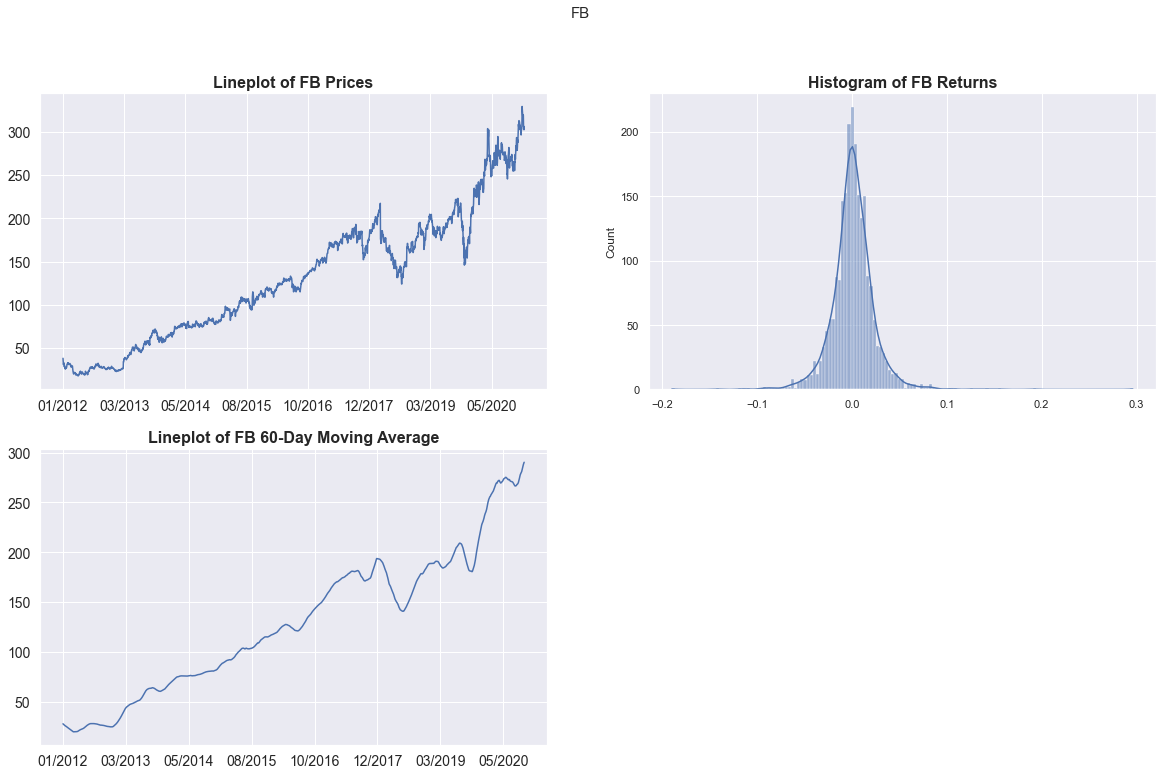

In [9]:
plotter('FB')

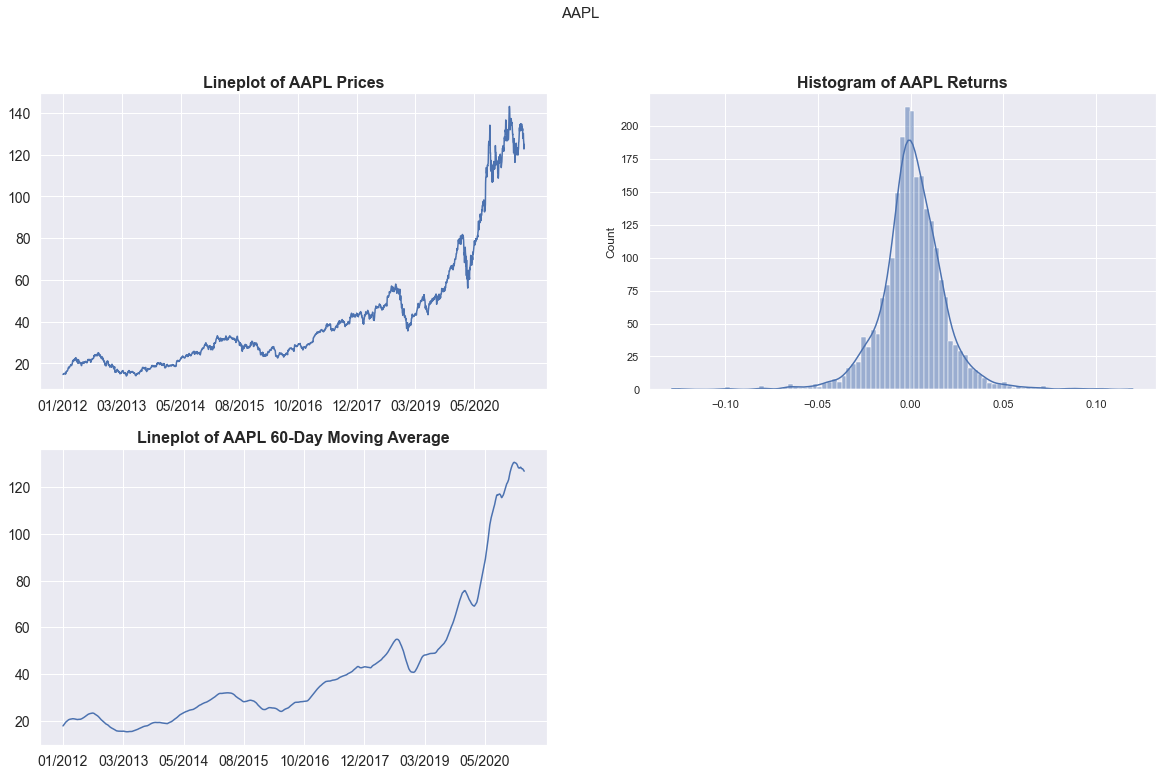

In [10]:
plotter('AAPL')

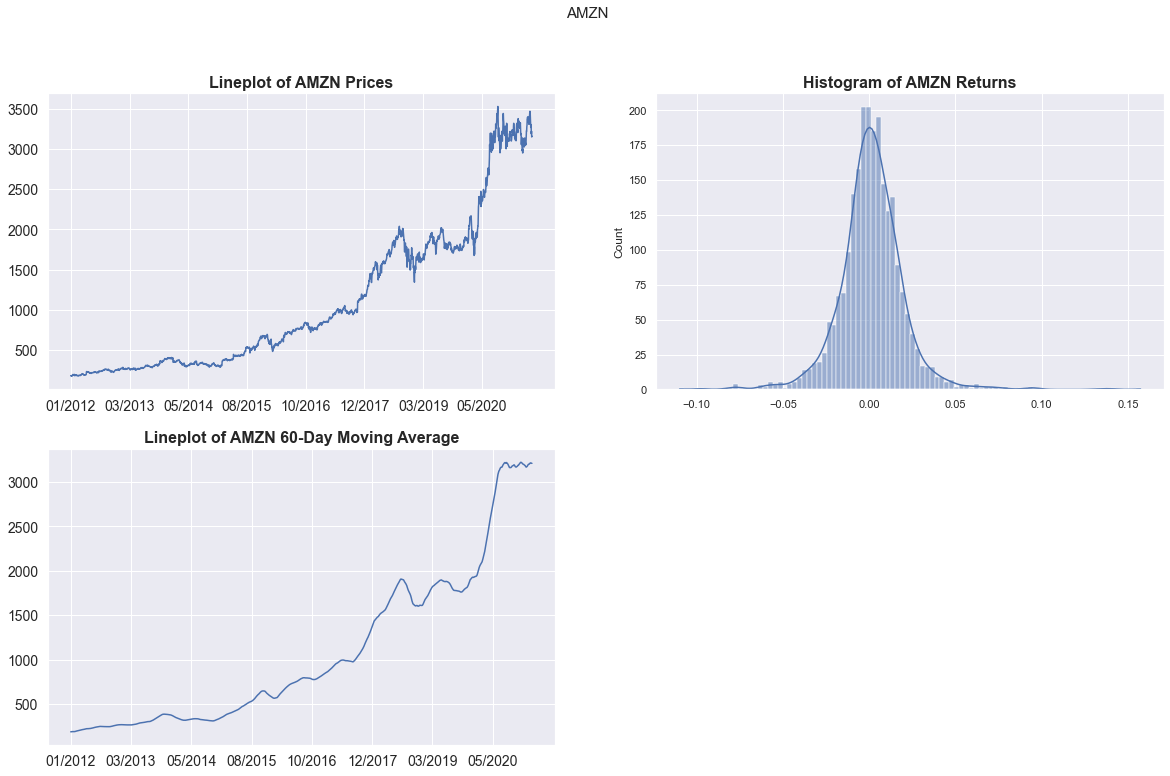

In [11]:
plotter('AMZN')

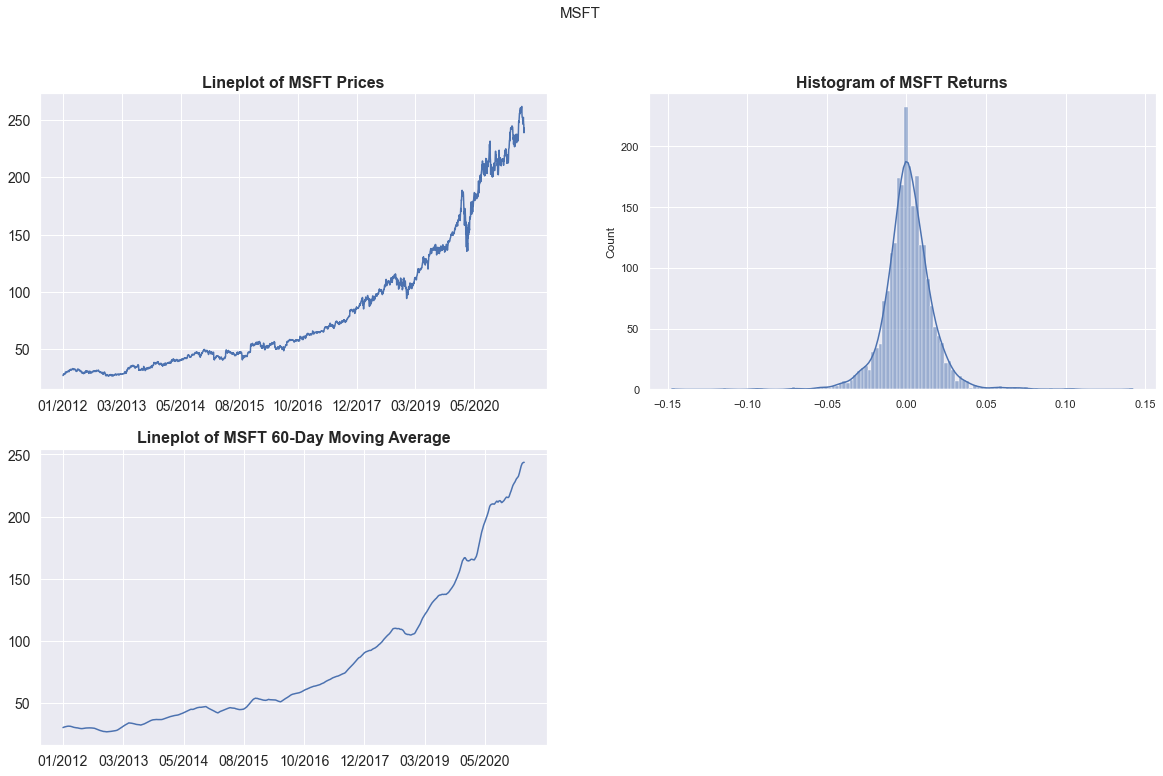

In [12]:
plotter('MSFT')

In [13]:
plotter('BTC-USD')

# Computer Experiments : Apply Neural Network

In [14]:
# market_symbol : for stocks traded in US markets just enter 'NYSE'
# window_days must be less than the difference bet test_start and test_end
def predict_prices(company, market_symbol, train_start, train_end, test_start,
                   test_end = None, window_days = 60, list_act_fun = [], list_arch = [3, 2, 1], iters = 1000, lrate = 0.1):
    
    if test_end == None:
        test_end = dt.datetime.now()
        
    if list_act_fun == []:
        list_act_fun = ['sigmoid', 'tanh', 'ReLU']
    
    stock_market_symbols = ['NYSE', 'NASDAQ']
    
    if market_symbol in stock_market_symbols:
        nyse = mcal.get_calendar(market_symbol)
        trading_dates = nyse.schedule(start_date = test_start, end_date = test_end)
        np_dates = trading_dates.to_numpy()
        dates = [np_dates[i][0].strftime('%m-%d-%Y') for i in range(len(np_dates))]
    else:
        nyse = mcal.get_calendar('24/7')
        test_start = test_start.strftime('%Y, %m, %d')
        test_end = test_end.strftime('%Y, %m, %d')
        trading_dates = nyse.schedule(start_date = test_start, end_date = test_end)
        np_dates = trading_dates.to_numpy()
        dates = pd.date_range(start=test_start,end=test_end).tolist()
        dates = [dates[i].strftime('%Y, %m, %d') for i in range(len(dates))]
        
    data = web.DataReader(company, 'yahoo', train_start, train_end)
    training_data = np.array(data['Close'])
    training_data = training_data.reshape(-1,1)
    
    '''Predict Stock'''
    # Load Test Data
    data = web.DataReader(company, 'yahoo', test_start, test_end)
    test_data = np.array(data['Close']).reshape(-1,1)
    total_test_dataset = np.concatenate((training_data[-window_days:], test_data), axis=0)
    list_loss = []
    test_mse = []
    test_vs_dma = []
    
    for function in list_act_fun:
        y_pred, y_test, dma, loss, wmax, wmin = run(training_data, total_test_dataset, 
                                                    architecture = list_arch, iters = iters, lrate = lrate,
                                                    window_days = window_days, activation_fun = function)
        list_loss.append(loss)
        
        test_errors = np.zeros(len(y_pred))
        for i in range(len(y_pred)):
            test_errors[i] = (y_pred[i] - y_test[i])**2
        test_mse.append(math.sqrt(test_errors.mean()))
        
        test_dma_errors = np.zeros(len(y_pred))
        for i in range(len(y_pred)):
            test_dma_errors[i] = (y_pred[i] - dma[i])**2
        test_vs_dma.append(math.sqrt(test_dma_errors.mean()))
        
        '''Plot the Predicted Results'''
        # Plot the Test Predictions
        plt.figure(figsize=(15,5))
        plt.plot(y_test, color='black', label=f'Actual {company} Price')
        plt.plot(y_pred, color='red', label=f'Predicted {company} Price')
        plt.plot(dma, color='blue', linestyle = 'dotted', label=f'{str(window_days)} Day Moving Average {company} Price')
        plt.plot(wmax, color='0.3', linestyle = 'dotted', label=f'{str(window_days)} Day Window Max {company} Price')
        plt.plot(wmin, color='0.3', linestyle = 'dotted', label=f'{str(window_days)} Day Window Min {company} Price')
        plt.title(f'{company} share price' f' predicted using {function} function', size=18)
        ticks = [i for i in range(len(dates)) if i % 10 == 0]
        labels = [dates[i] for i in ticks]
        plt.yticks(size=14)
        plt.xticks(ticks,labels, rotation=90, size=14)
        plt.xlabel('Date', size=14)
        plt.ylabel(f'{company} Share Price in USD', size=14)
        plt.legend()
        plt.show()
    
    t = PrettyTable(['Activation Function', 'Training Loss', 'Test RMSE', f'{str(window_days)}DMA RMSE'])
    for i in range(len(list_act_fun)):
        t.add_row([list_act_fun[i], list_loss[i], format(test_mse[i], 'f'), format(test_vs_dma[i], 'f')])
    print(t)

In [15]:
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

## Apply Neural Network to Facebook Stock Data 

Activation function is:  sigmoid


Activation function is:  tanh


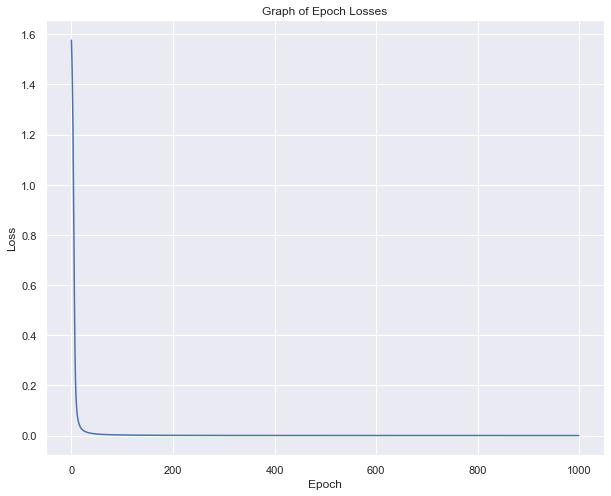

Activation function is:  ReLU


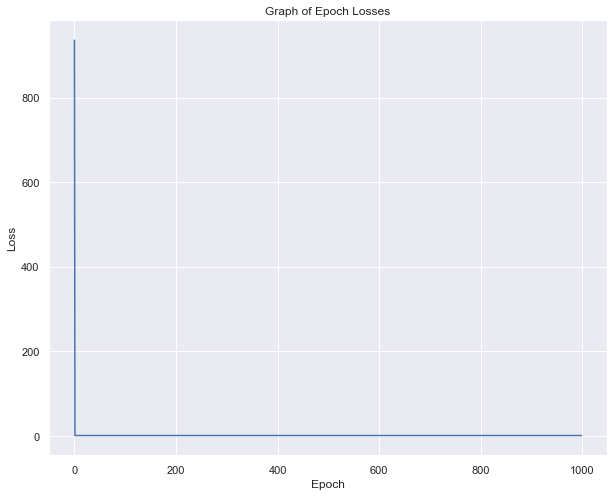

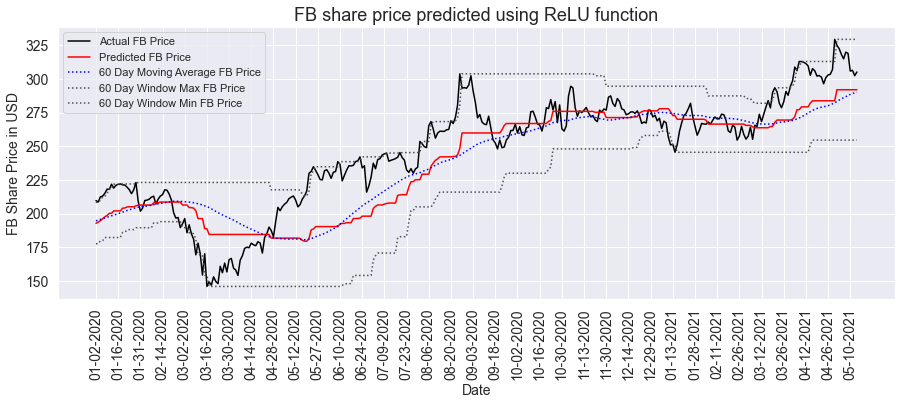

+---------------------+---------------+-----------+------------+
| Activation Function | Training Loss | Test RMSE | 60DMA RMSE |
+---------------------+---------------+-----------+------------+
|       sigmoid       |    0.468496   | 21.335551 |  5.929353  |
|         tanh        |    0.000022   | 31.381155 | 15.955385  |
|         ReLU        |    0.463316   | 21.376107 |  5.929558  |
+---------------------+---------------+-----------+------------+


In [16]:
predict_prices('FB', 'NYSE', start, end, test_start)

Here we see the tanh model display 'overfitting' - its Training Loss is extremely low compared to the other models, but it is worse at predicting testing data. It severely overweights the min-price input compared to the moving-average and max-price inputs.

The sigmoid model is the most accurate in this case, but takes the longest to converge. The ReLU model is slightly less accurate but converges the fastest.

##  Apply Neural Network to Apple Stock Data

Activation function is:  sigmoid


Activation function is:  tanh


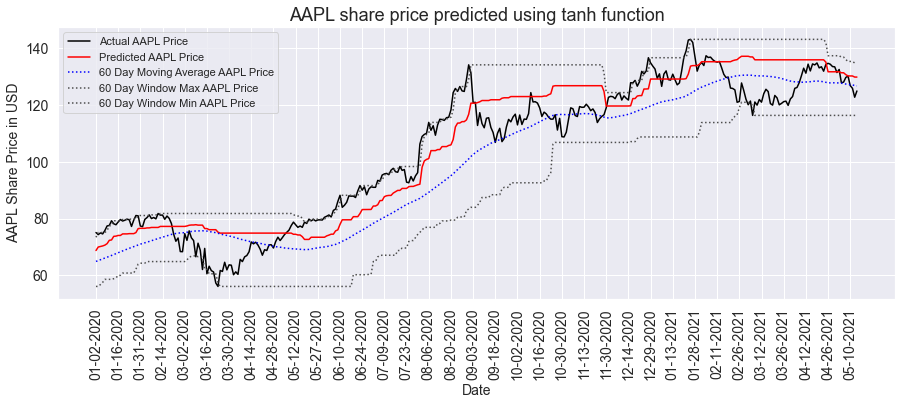

Activation function is:  ReLU


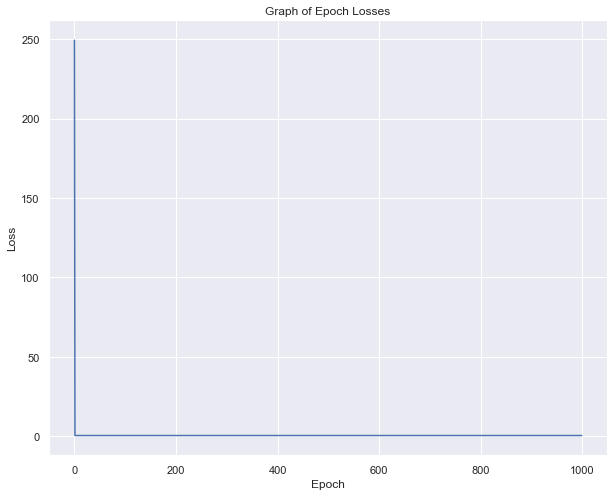

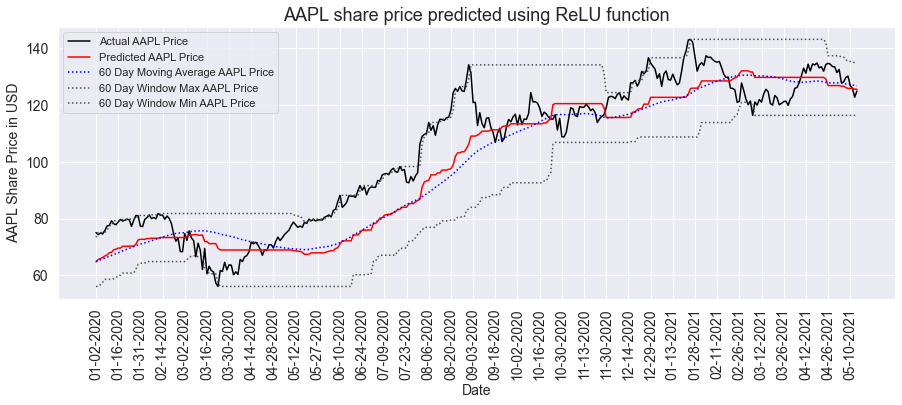

+---------------------+---------------+-----------+------------+
| Activation Function | Training Loss | Test RMSE | 60DMA RMSE |
+---------------------+---------------+-----------+------------+
|       sigmoid       |    0.000120   |  8.335449 |  7.688911  |
|         tanh        |    0.000000   |  8.352700 |  7.791311  |
|         ReLU        |    0.427630   |  9.734644 |  2.435548  |
+---------------------+---------------+-----------+------------+


In [17]:
predict_prices('AAPL', 'NYSE', start, end, test_start)

In the AAPL case the sigmoid model is the most accurate, but takes the longest to converge. tanh model converges slightly faster but is slightly less accurate.

The ReLU model in this case is not able to fit the training data as well or predict the test data as accurately. It converges rapidly but poorly, and heavily overweighs the moving-average input compared to the other factors.

##  Apply Neural Network to Amazon Stock Data

Activation function is:  sigmoid


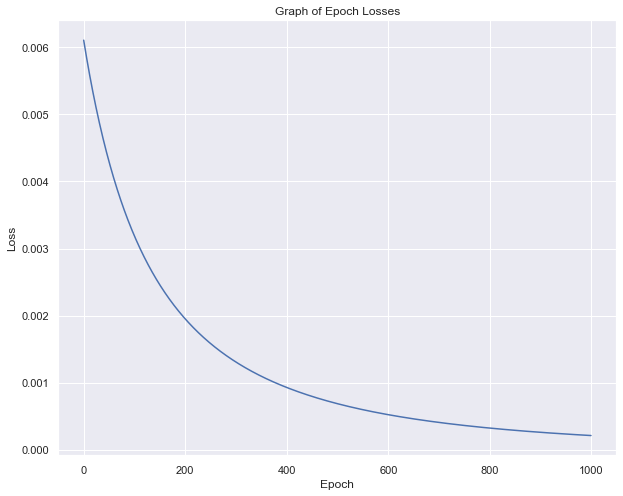

Activation function is:  tanh


Activation function is:  ReLU


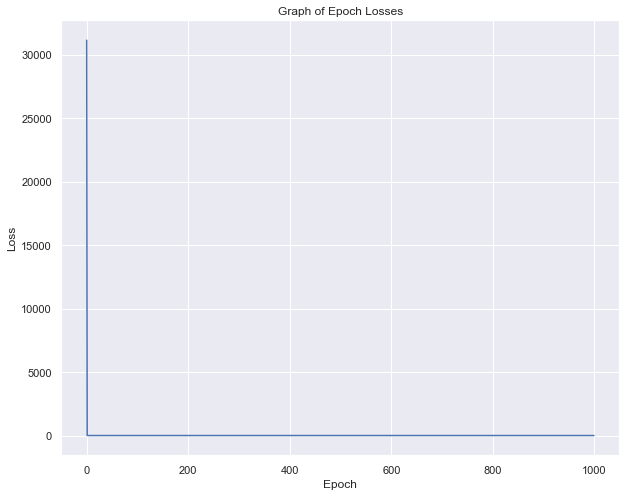

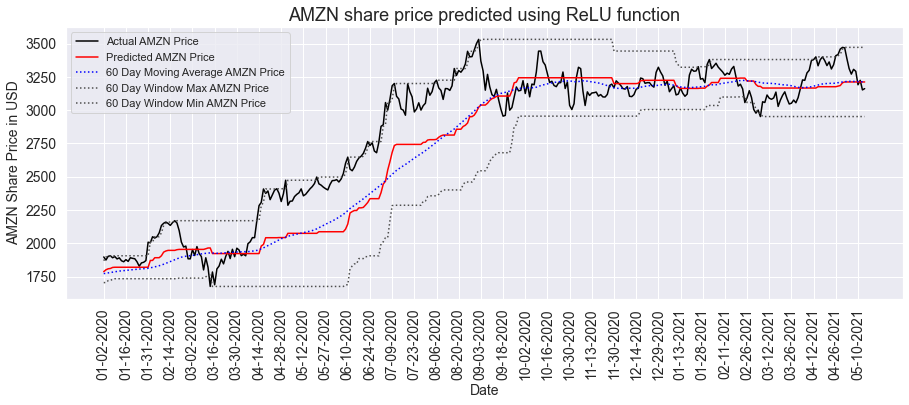

+---------------------+---------------+------------+------------+
| Activation Function | Training Loss | Test RMSE  | 60DMA RMSE |
+---------------------+---------------+------------+------------+
|       sigmoid       |    0.000211   | 168.979741 | 158.055270 |
|         tanh        |    0.000002   | 168.787855 | 160.717185 |
|         ReLU        |    0.445330   | 227.603518 | 49.288182  |
+---------------------+---------------+------------+------------+


In [18]:
predict_prices('AMZN', 'NYSE', start, end, test_start)

The AMZN case is similar to the AAPL case, except the tanh model this time does slightly outperform the sigmoid model on fit and accuracy in addition to convergence speed.

Once again the ReLU converges rapidly but overweights the moving-average input.

##  Apply Neural Network to Microsoft Stock Data 

Activation function is:  sigmoid


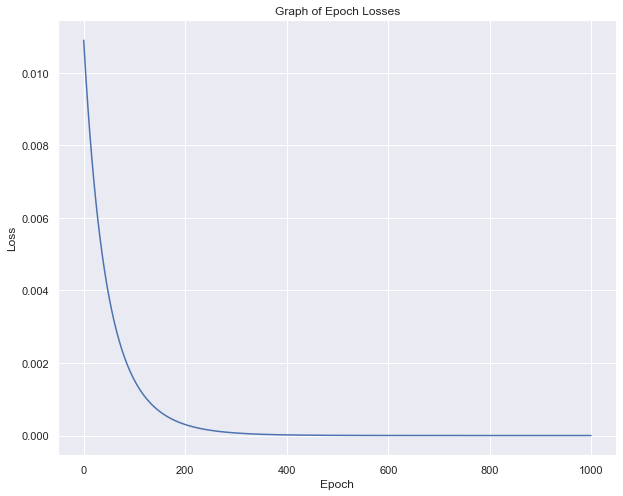

Activation function is:  tanh


Activation function is:  ReLU


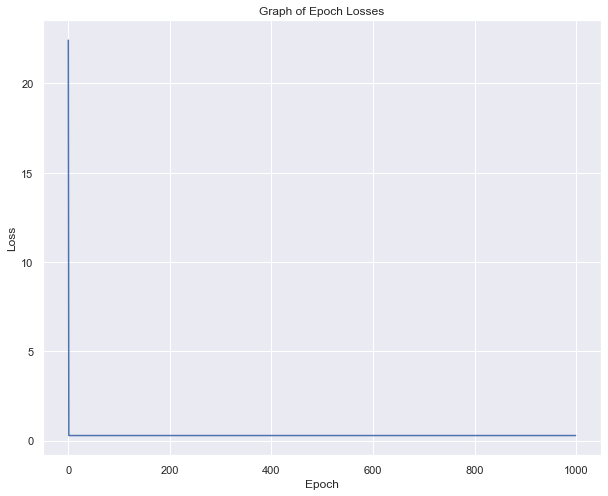

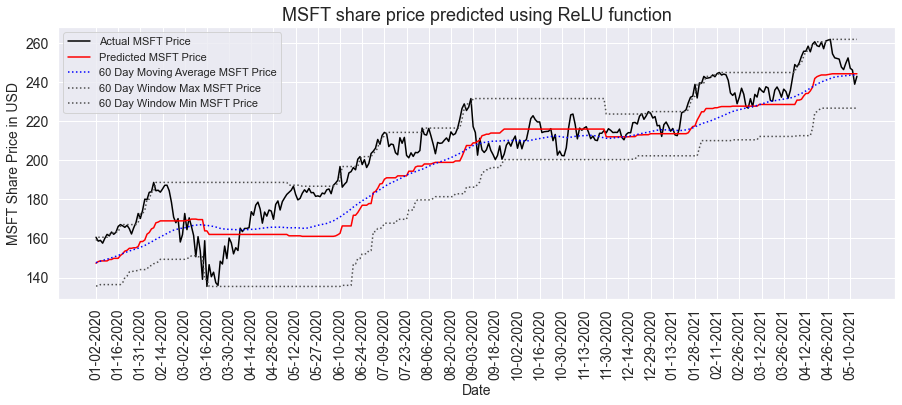

+---------------------+---------------+-----------+------------+
| Activation Function | Training Loss | Test RMSE | 60DMA RMSE |
+---------------------+---------------+-----------+------------+
|       sigmoid       |    0.000000   | 11.225579 |  8.163234  |
|         tanh        |    0.000000   | 11.225473 |  8.164127  |
|         ReLU        |    0.288700   | 14.053726 |  3.598621  |
+---------------------+---------------+-----------+------------+


In [19]:
predict_prices('MSFT', 'NYSE', start, end, test_start)

On MSFT the tanh and sigmoid models have extremely similar performance, though th tanh takes fewer iterations to converge.

The ReLU is once again overweighting the moving-average and is noticeably worse on both fit and accuracy.

##  Apply Neural Network to Bitcoin Stock Data 

Activation function is:  sigmoid


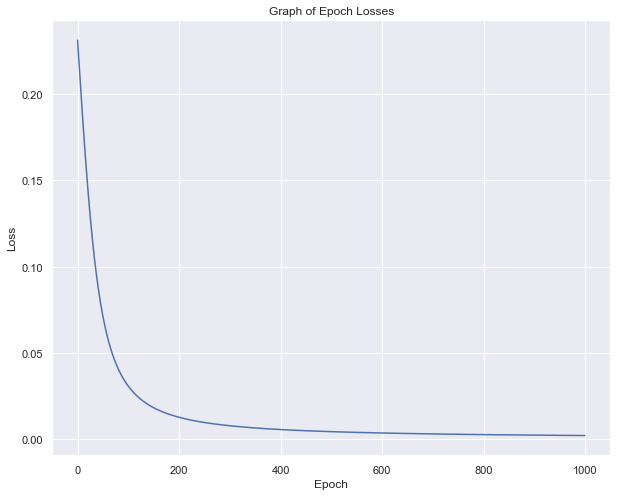

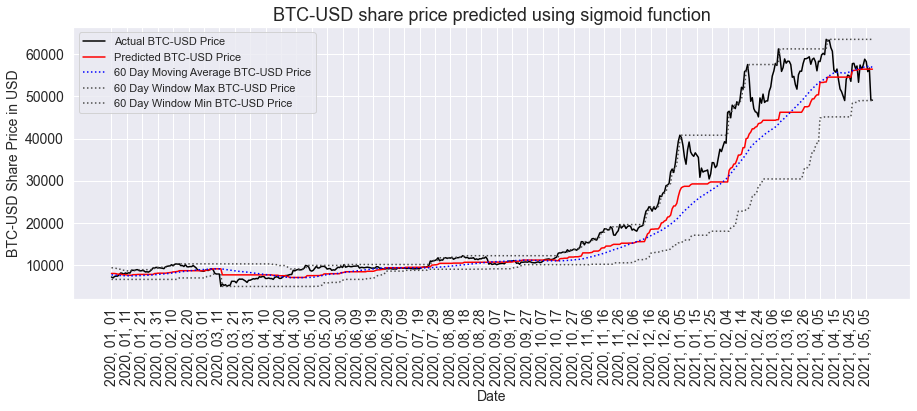

Activation function is:  tanh


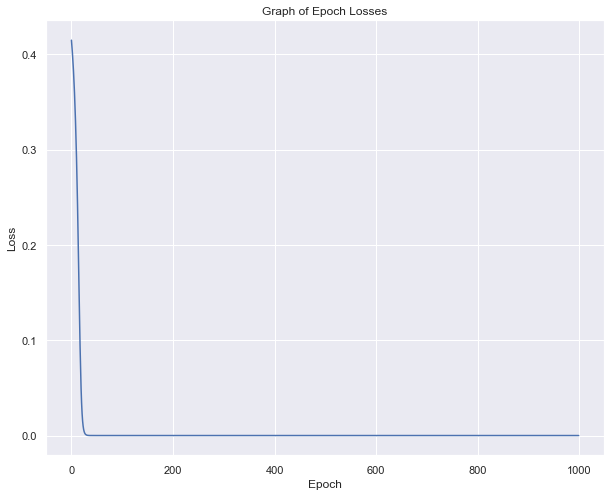

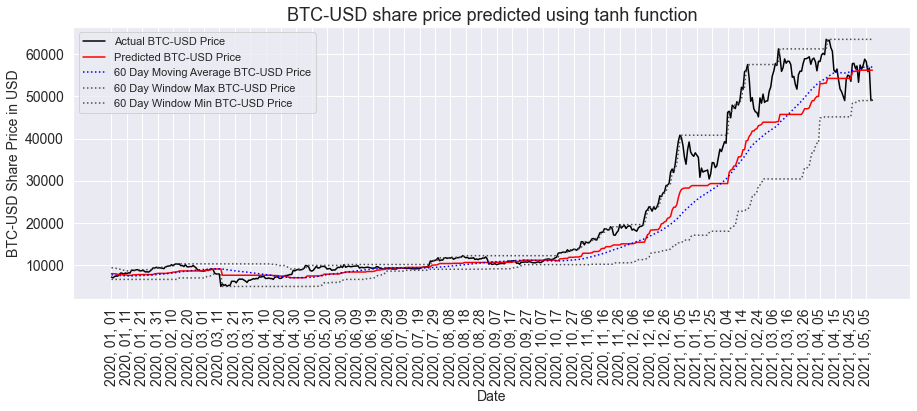

Activation function is:  ReLU


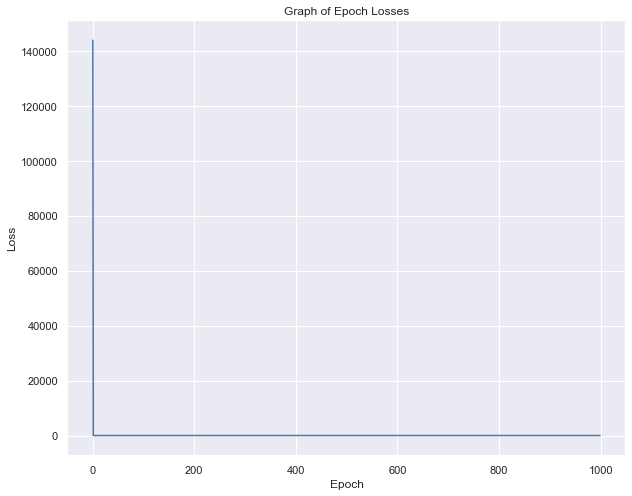

+---------------------+---------------+-------------+-------------+
| Activation Function | Training Loss |  Test RMSE  |  60DMA RMSE |
+---------------------+---------------+-------------+-------------+
|       sigmoid       |    0.002221   | 4827.045397 | 1395.120456 |
|         tanh        |    0.000000   | 5014.548854 | 1307.463833 |
|         ReLU        |    0.000116   | 4971.516323 | 1324.750377 |
+---------------------+---------------+-------------+-------------+


In [20]:
predict_prices('BTC-USD', '24/7', start, end, test_start)

On BTC data the tanh model displays minor overfitting and suffers a loss of test accuracy. Interestingly the ReLU model is also able to achieve a better training fit than the sigmoid, but is also slightly less accurate on the test data compared to sigmoid. As usual the sigmoid model takes the longest to converge.

We see an overall pattern with our 3 activation functions: sigmoid converges the slowest but shows the best accuracy, ReLU converges fastest but has worse accuracy in general, and tanh is in-between on both speed and accuracy but prone to occasional overfitting.

We select the sigmoid activation function to hold constant for further experiments, in which we will alter other neural network 'hyperparameters' to study their effects on stock price prediction.

## Parameter Experiments

Our first experiment is to increase the number of backpropagation iterations to 10 times their normal amount, holding all other network parameters as constant.

In [21]:
predict_prices('FB', 'NYSE', start, end, test_start, list_act_fun = ['sigmoid'],
               iters = 10000)

Activation function is:  sigmoid


+---------------------+---------------+-----------+------------+
| Activation Function | Training Loss | Test RMSE | 60DMA RMSE |
+---------------------+---------------+-----------+------------+
|       sigmoid       |    0.463818   | 21.372150 |  5.929487  |
+---------------------+---------------+-----------+------------+


Compared to our original specifications (with 1000 iterations) using FB data, increasing our iterations by a factor of 10 marginally improves our training fit but does not increase the test accuracy of our model. The sigmoid model is essentially able to converge within the original 1000 iterations, so the remaining 9000 do not achieve much improvement.

Our next experiment is to decrease the number of backpropagation iterations to 1/10th their normal amount, holding all other network parameters as constant.

Activation function is:  sigmoid


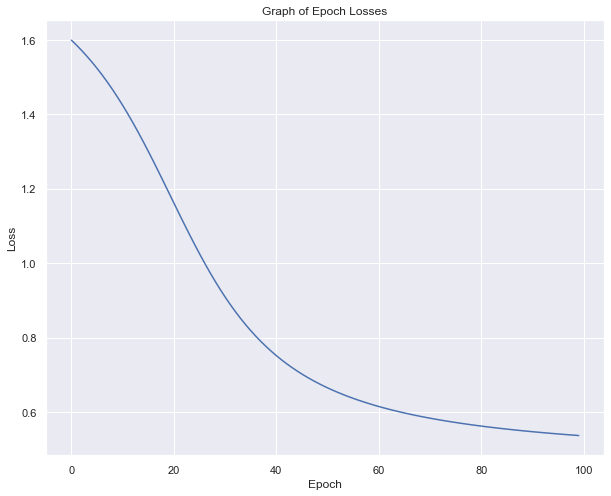

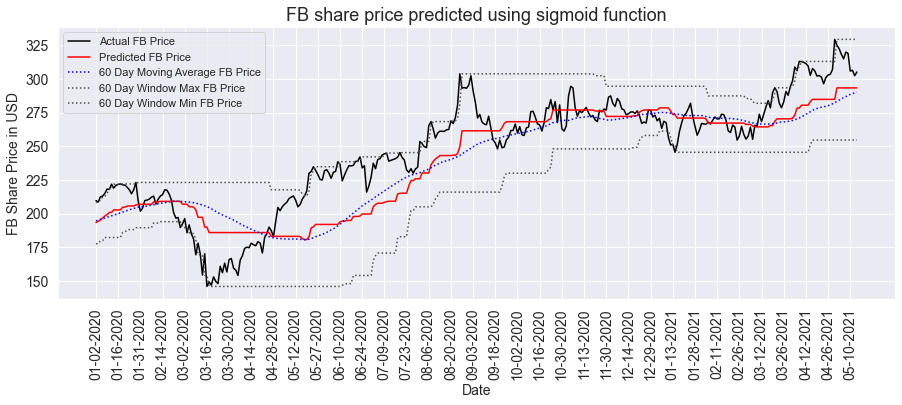

+---------------------+---------------+-----------+------------+
| Activation Function | Training Loss | Test RMSE | 60DMA RMSE |
+---------------------+---------------+-----------+------------+
|       sigmoid       |    0.536877   | 20.847815 |  6.024235  |
+---------------------+---------------+-----------+------------+


In [22]:
predict_prices('FB', 'NYSE', start, end, test_start, list_act_fun = ['sigmoid'],
               iters = 100)

With less time available to iterate the sigmoid model is not quite able to converge and achieves a worse training fit than before. Interestingly, this does not harm its test data accuracy and it actually achieves a better test RMSE than before.

Our next experiment is to shrink the learning rate hyperparameter to 1/10th its normal amount, holding all other network parameters as constant.

Activation function is:  sigmoid


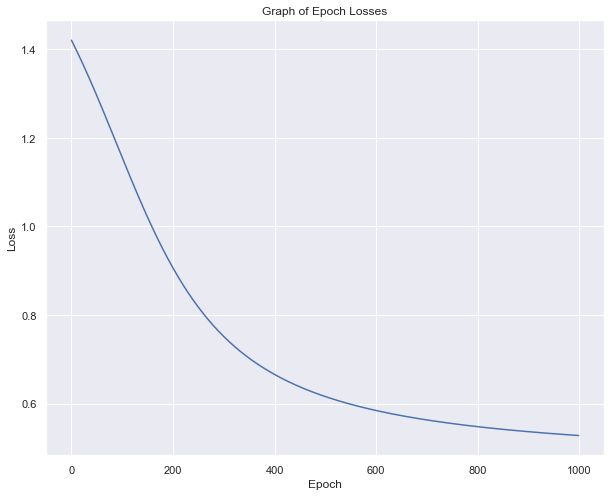

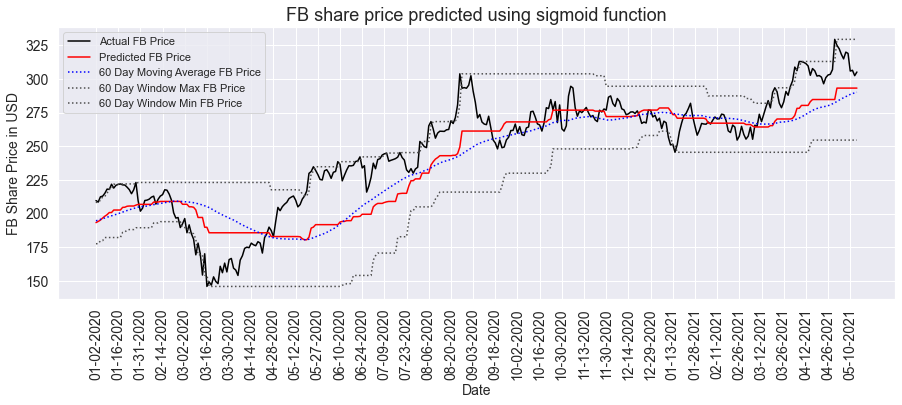

+---------------------+---------------+-----------+------------+
| Activation Function | Training Loss | Test RMSE | 60DMA RMSE |
+---------------------+---------------+-----------+------------+
|       sigmoid       |    0.527760   | 20.903375 |  6.003739  |
+---------------------+---------------+-----------+------------+


In [23]:
predict_prices('FB', 'NYSE', start, end, test_start, list_act_fun = ['sigmoid'],
               lrate = 0.01)

The result achieved is similar to the one seen when reducing our iterations. As the network learns slower, it is not quite able to converge in the alotted time, but again actually ends up doing better on the test data than the 'properly' fitted network.

Our next experiment is to increase the learning rate hyperparameter to 10 times its normal amount, holding all other network parameters as constant.

Activation function is:  sigmoid


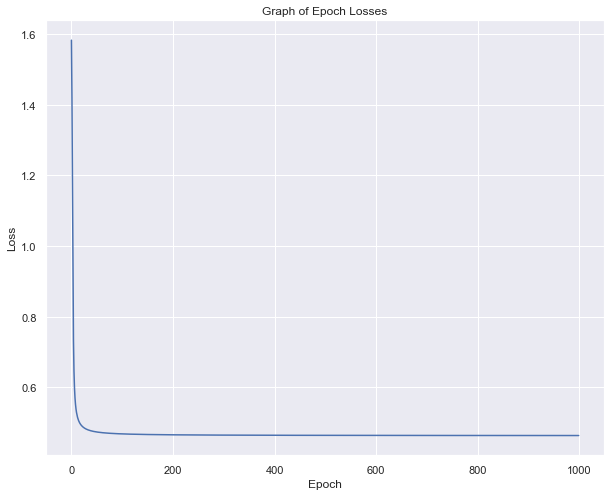

+---------------------+---------------+-----------+------------+
| Activation Function | Training Loss | Test RMSE | 60DMA RMSE |
+---------------------+---------------+-----------+------------+
|       sigmoid       |    0.463817   | 21.372158 |  5.929488  |
+---------------------+---------------+-----------+------------+


In [24]:
predict_prices('FB', 'NYSE', start, end, test_start, list_act_fun = ['sigmoid'],
               lrate = 1)

The result seen here is similar to the case where we increased our backpropagation iterations by a factor of 10. As the network learns faster, it achieves a quicker convergence, then oscillates around its best fit point for the remainder of the time. The ultimate fit is similar to the one our default parameters produce and the larger learning steps do not seem to result in any loss of fit or test accuracy.

Our next experiment is to increase the width of the hidden layer from 2 to 8 'neuron' units, holding all other network parameters as constant.

Activation function is:  sigmoid


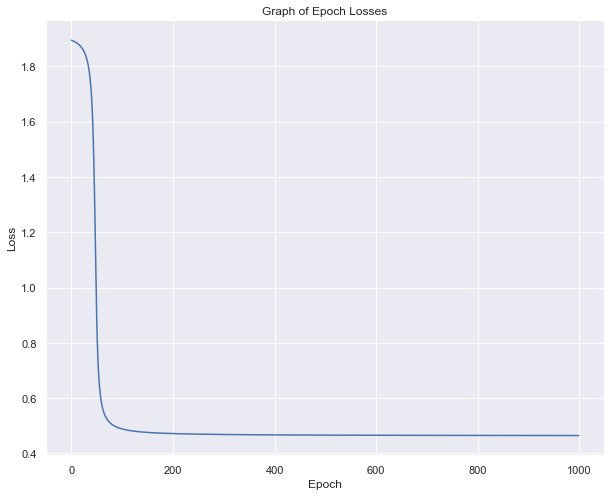

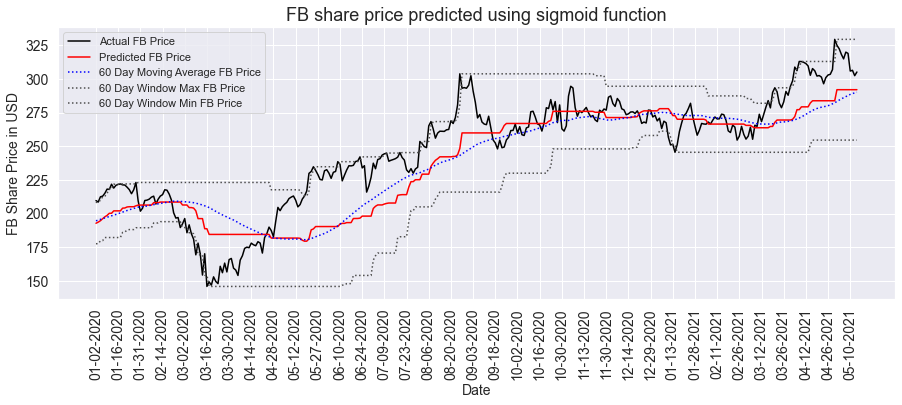

+---------------------+---------------+-----------+------------+
| Activation Function | Training Loss | Test RMSE | 60DMA RMSE |
+---------------------+---------------+-----------+------------+
|       sigmoid       |    0.464636   | 21.365725 |  5.929396  |
+---------------------+---------------+-----------+------------+


In [25]:
predict_prices('FB', 'NYSE', start, end, test_start, list_act_fun = ['sigmoid'],
               list_arch = [3, 8, 1])

Our wider network interestingly achieves convergence slightly faster than our default network did. The training fit is slightly better than the one produced by our default model but the test data accuracy does not appear to be any better.

Our next experiment involves changing the length of the input parameters' 'sliding windows' from the default 60 days to 10 days, holding all network parameters constant.

Activation function is:  sigmoid


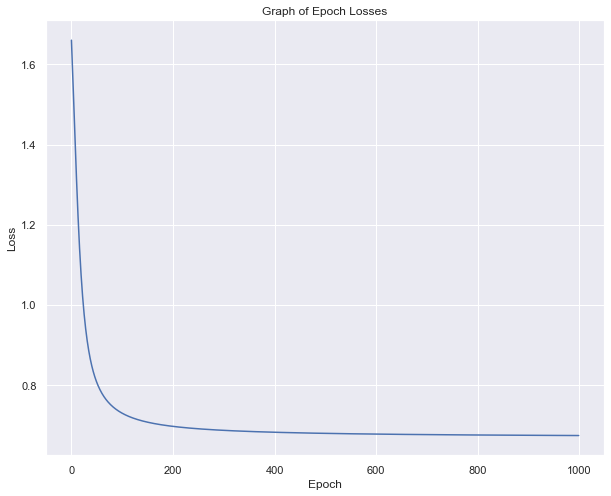

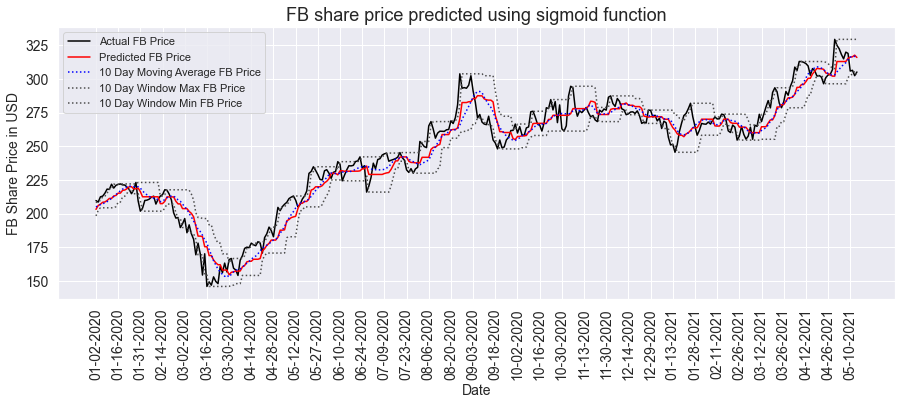

+---------------------+---------------+-----------+------------+
| Activation Function | Training Loss | Test RMSE | 10DMA RMSE |
+---------------------+---------------+-----------+------------+
|       sigmoid       |    0.673371   | 10.261478 |  2.273697  |
+---------------------+---------------+-----------+------------+


In [26]:
predict_prices('FB', 'NYSE', start, end, test_start, list_act_fun = ['sigmoid'],
               window_days = 10)

The result of our shorter sliding windows is that the model becomes very heavily biased to recent data. As such it _appears_ to be achieving a tighter test RMSE data fit, but this is because it the inputs (10-day moving average, window max and min) stick more tightly to the price time series and not because the neural network itself is performing any better.

As we will see in our trading simulation, very short windows are not beneficial to making predictions. The network inputs are lagging technical indicators and the network becoming heavily biased to a smaller set of lagging indicators (as opposed to longer-range patterns) causes its predictions to also lag actual market moves - a phenomenon which is visible in the graph above.

Our final experiment involves changing the length of the input parameters' 'sliding windows' from the default 60 days to 100 days, holding all network parameters constant.

Activation function is:  sigmoid


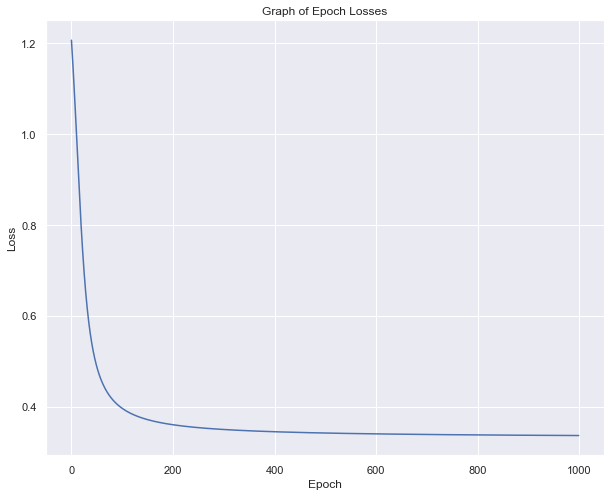

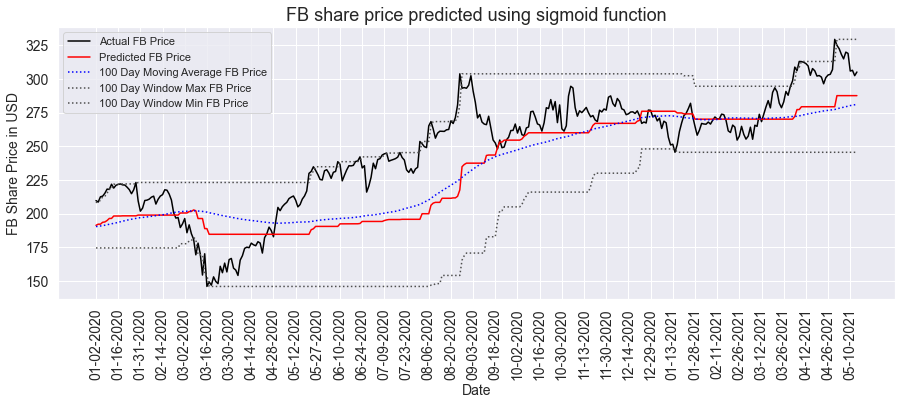

+---------------------+---------------+-----------+-------------+
| Activation Function | Training Loss | Test RMSE | 100DMA RMSE |
+---------------------+---------------+-----------+-------------+
|       sigmoid       |    0.336205   | 27.667562 |   6.106425  |
+---------------------+---------------+-----------+-------------+


In [27]:
predict_prices('FB', 'NYSE', start, end, test_start, list_act_fun = ['sigmoid'],
               window_days = 100)

The very long sliding window results in our prediction prices remaining horizontal for long stretches of time, as the window max and min prices change much less frequently and the daily moving average does not change quickly enough to 'fire' the neurons that would alter the output price based on it.

# Results : Trading Simulation

In this section we create a basic trading algorithm based on our neural network predictions. Transaction costs and other market frictions do not exist for the purpose of this simulation.

Our data is based on daily market close figures and our predictions are also daily, so our algorithm will also make 1 trade per day.

Every day before market close, we close any existing position we had, run our prediction and decide what to do for the next day. We know our prediction prices are more closely aligned to moving averages than to actual price data, so we compare our prediction for tomorrow to the latest moving average data. If the prediction is higher, we buy 1 share (which we will sell before close tomorrow). If the prediction is lower, we short one share.

This procedure is repeated daily for the length of our test data. A simple buy-&-hold strategy over the same duration is used as a comparison benchmark.

In [28]:
def predict_trades(company, market_symbol, train_start, train_end, test_start,
                   test_end = None, window_days = 60, act_fun = 'sigmoid', list_arch = [3, 2, 1], iters = 1000, lrate = 0.1):
    
    if test_end == None:
        test_end = dt.datetime.now()
        
    if act_fun not in ['sigmoid', 'tanh', 'ReLU']:
        return
    
    stock_market_symbols = ['NYSE', 'NASDAQ']
    
    if market_symbol in stock_market_symbols:
        nyse = mcal.get_calendar(market_symbol)
        trading_dates = nyse.schedule(start_date = test_start, end_date = test_end)
        np_dates = trading_dates.to_numpy()
        dates = [np_dates[i][0].strftime('%m-%d-%Y') for i in range(len(np_dates))]
    else:
        nyse = mcal.get_calendar('24/7')
        test_start = test_start.strftime('%Y, %m, %d')
        test_end = test_end.strftime('%Y, %m, %d')
        trading_dates = nyse.schedule(start_date = test_start, end_date = test_end)
        np_dates = trading_dates.to_numpy()
        dates = pd.date_range(start=test_start,end=test_end).tolist()
        dates = [dates[i].strftime('%Y, %m, %d') for i in range(len(dates))]
        
    data = web.DataReader(company, 'yahoo', train_start, train_end)
    training_data = np.array(data['Close'])
    training_data = training_data.reshape(-1,1)
    
    '''Predict Stock'''
    # Load Test Data
    data = web.DataReader(company, 'yahoo', test_start, test_end)
    test_data = np.array(data['Close']).reshape(-1,1)
    total_test_dataset = np.concatenate((training_data[-window_days:], test_data), axis=0)
    
    y_pred, y_test, dma, loss, wmax, wmin = run(training_data, total_test_dataset, 
                                                architecture = list_arch, iters = iters, lrate = lrate,
                                                window_days = window_days, activation_fun = act_fun, graph = False)
    
    '''Plot the Predicted Results'''
    # Plot the Test Predictions
    plt.figure(figsize=(15,5))
    plt.plot(y_test, color='black', label=f'Actual {company} Price')
    plt.plot(y_pred, color='red', label=f'Predicted {company} Price')
    plt.plot(dma, color='blue', linestyle = 'dotted', label=f'{str(window_days)} Day Moving Average {company} Price')
    plt.plot(wmax, color='0.3', linestyle = 'dotted', label=f'{str(window_days)} Day Window Max {company} Price')
    plt.plot(wmin, color='0.3', linestyle = 'dotted', label=f'{str(window_days)} Day Window Min {company} Price')
    plt.title(f'{company}', size=18)
    ticks = [i for i in range(len(dates)) if i % 10 == 0]
    labels = [dates[i] for i in ticks]
    plt.xticks(ticks,labels, rotation=90)
    plt.xlabel('Date', size=14)
    plt.ylabel(f'{company} Share Price in USD', size=14)
    plt.legend()
    plt.show()
    
    return y_pred, y_test, dma, dates

In [29]:
def trade(company, market_symbol, train_start, train_end, test_start,
          test_end = None, window_days = 60, act_fun = 'sigmoid', list_arch = [3, 2, 1], iters = 1000, lrate = 0.1):
    
    pred, test, dma, dates = predict_trades(company, market_symbol, train_start, train_end,
                                            test_start, test_end, window_days, act_fun,
                                            list_arch, iters, lrate)
    
    longpnl = []
    lspnl = []
    
    roll_longpnl = []
    roll_lspnl = []
    roll_buyhold = []
    
    for i in range(1, len(pred)):
        if pred[i] > dma[i-1]:
            longpnl.append(test[i] - test[i-1])
            lspnl.append(test[i] - test[i-1])
        elif pred[i] < dma[i-1]:
            longpnl.append(0)
            lspnl.append(test[i-1] - test[i])
        else:
            longpnl.append(0)
            lspnl.append(0)
            
        roll_longpnl.append(sum(longpnl))
        roll_lspnl.append(sum(lspnl))
        roll_buyhold.append(test[i] - test[0])
    
    plt.figure(figsize=(15,5))
    plt.plot(roll_buyhold, color='black', label=f'Buy & Hold {company}')
    plt.plot(roll_longpnl, color='blue', label=f'NN Long-Only {company}')
    plt.plot(roll_lspnl, color='red', label=f'NN Long/Short {company}')
    plt.title(f'{company}', size=18)
    ticks = [i for i in range(len(dates)) if i % 10 == 0]
    labels = [dates[i] for i in ticks]
    plt.xticks(ticks, labels, rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Profit/Loss in USD', size=14)
    plt.legend()
    plt.show()
    
    long_only = sum(longpnl)
    longshort = sum(lspnl)
    buyhold = test[len(test) - 1] - test[0]
    
    return long_only, longshort, buyhold

The network architecture used for our trading simulation is an enhanced variant of our original network. We have decreased the sliding window length from 60 to 30 days, increased the hidden layer width to 6 units, increased the iterations by a factor of 10 and shrunk the learning rate by the same factor. The activation function used is sigmoid.

Activation function is:  sigmoid


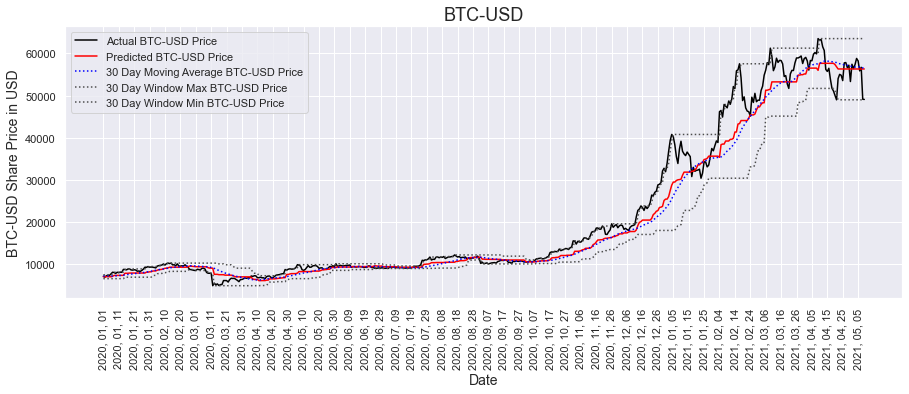

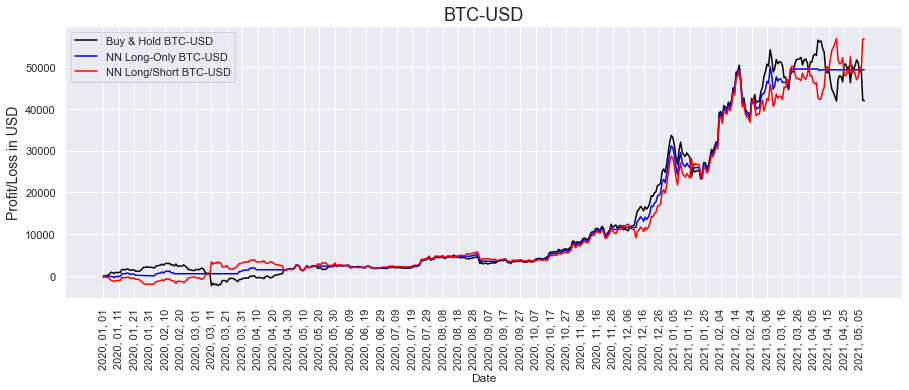

Long Only Strategy:  $49242
Long-Short Strategy: $56591
Buy & Hold Strategy: $41893


In [30]:
long_only, longshort, buyhold = trade(company = 'BTC-USD', market_symbol = '24/7', train_start = start, train_end = end,
                                      test_start = test_start, test_end = None, window_days = 30,
                                      act_fun = 'sigmoid', list_arch = [3, 6, 1], iters = 10000, lrate = 0.01)

print('Long Only Strategy:  $' + str(int(long_only)))
print('Long-Short Strategy: $' + str(int(longshort)))
print('Buy & Hold Strategy: $' + str(int(buyhold)))

Our strategy works well on BTC, with the network correctly able to avoid some down days and outperform the buy-and-hold benchmark. The long-short strategy profits off of correctly-identified down days and is thus able to generate greater revenue than the long-only version of the strategy (which simply stays out of the market on down days).

Activation function is:  sigmoid


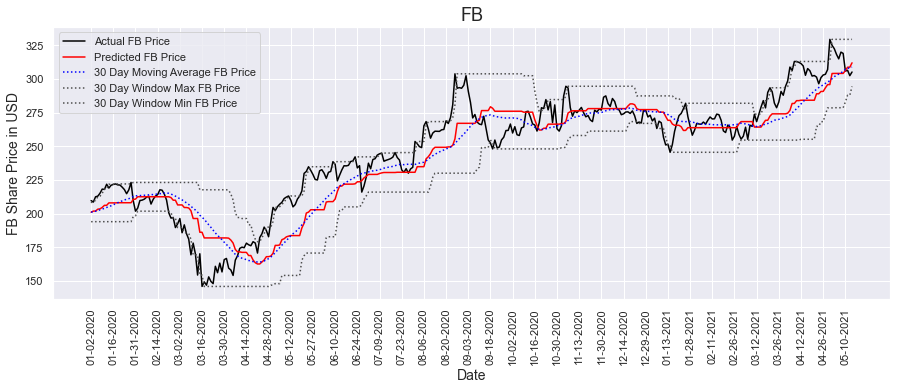

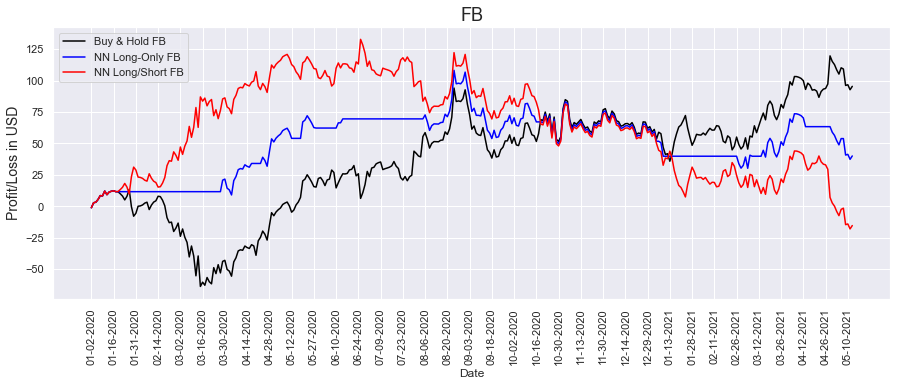

Long Only Strategy:  $40
Long-Short Strategy: $-15
Buy & Hold Strategy: $95


In [31]:
long_only, longshort, buyhold = trade(company = 'FB', market_symbol = 'NYSE', train_start = start, train_end = end,
                                      test_start = test_start, test_end = None, window_days = 30,
                                      act_fun = 'sigmoid', list_arch = [3, 6, 1], iters = 10000, lrate = 0.01)

print('Long Only Strategy:  $' + str(int(long_only)))
print('Long-Short Strategy: $' + str(int(longshort)))
print('Buy & Hold Strategy: $' + str(int(buyhold)))

On FB data the network falters and is seen misidentifying the direction most days will take. The long-only strategy still generates some revenue but is heavily outperformed by simply buying and holding for the length of the test data. The long-short strategy takes additional risks and produces a net loss.

Activation function is:  sigmoid


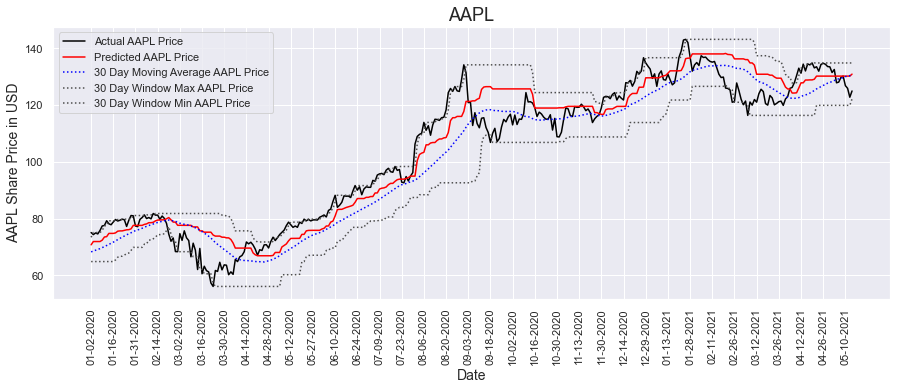

Long Only Strategy:  $52
Long-Short Strategy: $55
Buy & Hold Strategy: $49


In [32]:
long_only, longshort, buyhold = trade(company = 'AAPL', market_symbol = 'NYSE', train_start = start, train_end = end,
                                      test_start = test_start, test_end = None, window_days = 30,
                                      act_fun = 'sigmoid', list_arch = [3, 6, 1], iters = 10000, lrate = 0.01)

print('Long Only Strategy:  $' + str(int(long_only)))
print('Long-Short Strategy: $' + str(int(longshort)))
print('Buy & Hold Strategy: $' + str(int(buyhold)))

On AAPL the network again gets most days right. The long-only trade gains a few dollars over the benchmark by avoiding down days while the long-short gains a few more by profiting off of down days.

Activation function is:  sigmoid


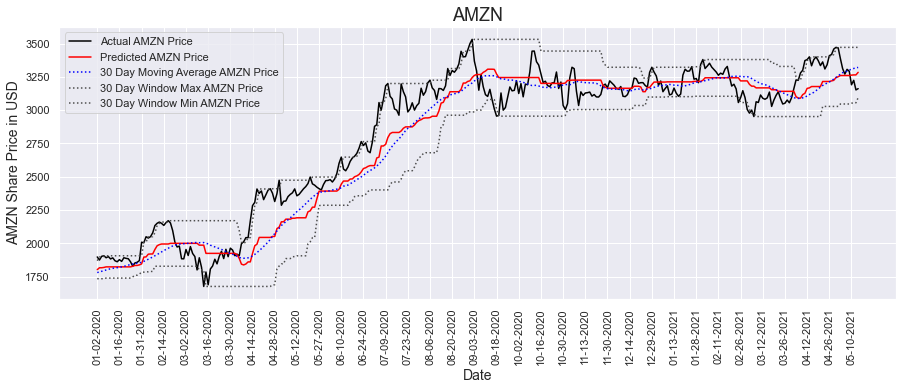

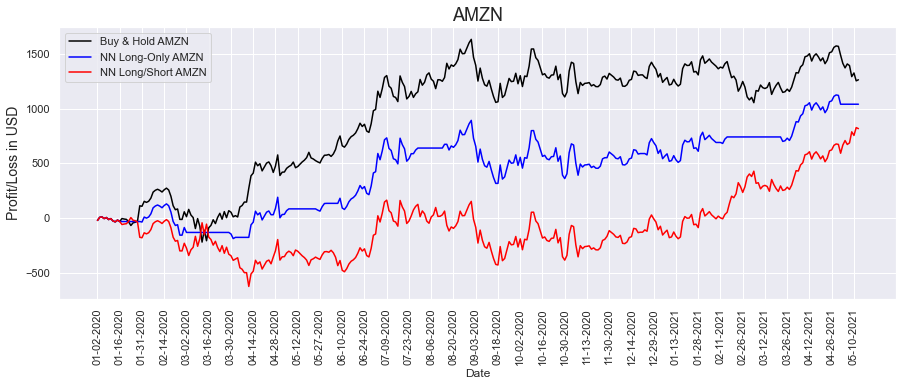

Long Only Strategy:  $1040
Long-Short Strategy: $816
Buy & Hold Strategy: $1263


In [33]:
long_only, longshort, buyhold = trade(company = 'AMZN', market_symbol = 'NYSE', train_start = start, train_end = end,
                                      test_start = test_start, test_end = None, window_days = 30,
                                      act_fun = 'sigmoid', list_arch = [3, 6, 1], iters = 10000, lrate = 0.01)

print('Long Only Strategy:  $' + str(int(long_only)))
print('Long-Short Strategy: $' + str(int(longshort)))
print('Buy & Hold Strategy: $' + str(int(buyhold)))

On AMZN the network is mostly wrong again, though not as disastrously bad as it was on FB. It misidentifies some days, causing the long-only trade to miss out on revenue while the long-short trade makes additional losses. The trading algorithm generates positive revenue but is outperformed by the benchmark.

Activation function is:  sigmoid


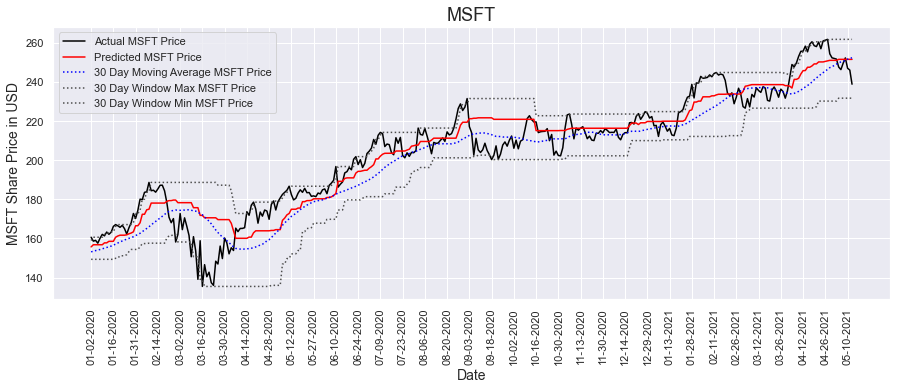

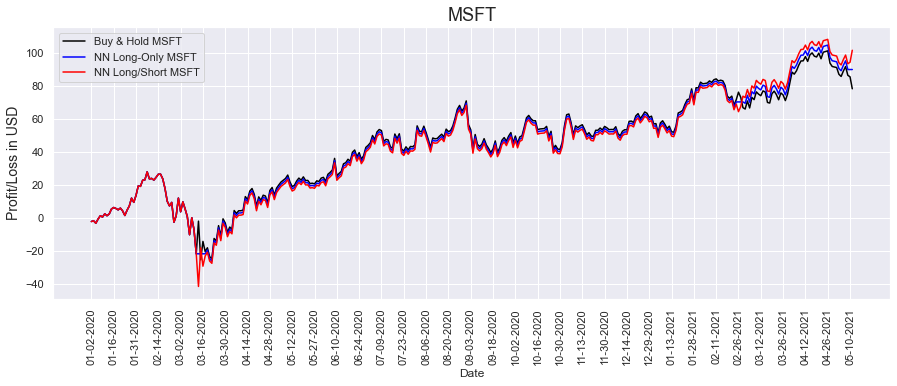

Long Only Strategy:  $90
Long-Short Strategy: $101
Buy & Hold Strategy: $78


In [34]:
long_only, longshort, buyhold = trade(company = 'MSFT', market_symbol = 'NYSE', train_start = start, train_end = end,
                                      test_start = test_start, test_end = None, window_days = 30,
                                      act_fun = 'sigmoid', list_arch = [3, 6, 1], iters = 10000, lrate = 0.01)

print('Long Only Strategy:  $' + str(int(long_only)))
print('Long-Short Strategy: $' + str(int(longshort)))
print('Buy & Hold Strategy: $' + str(int(buyhold)))

MSFT is another success for our little neural network, producing a tidy profit over the benchmark.

### Overall Market

Finally, we will check our network's performance on the broad stock market. We use a Vanguard S&P500 ETF 'VOO' for this purpose.

Activation function is:  sigmoid


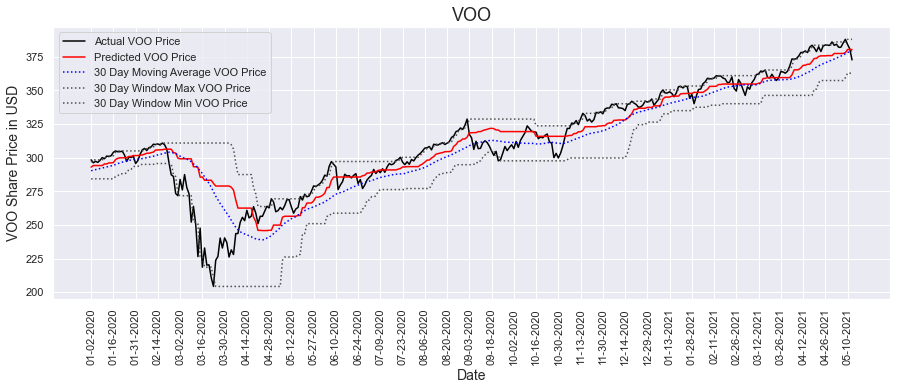

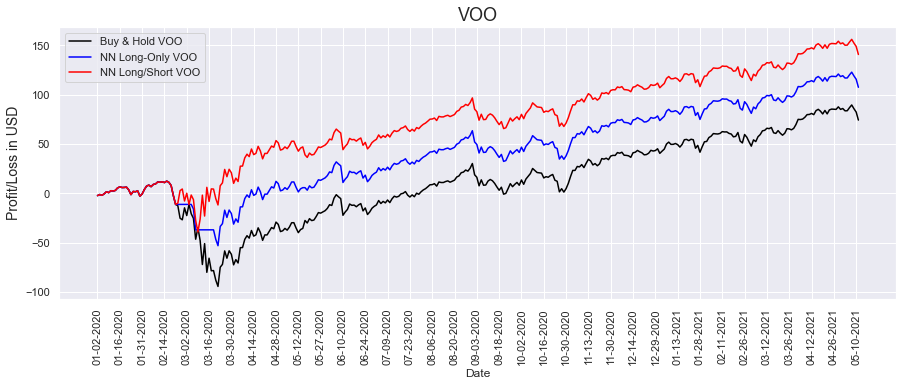

Long Only Strategy:  $107
Long-Short Strategy: $140
Buy & Hold Strategy: $74


In [35]:
long_only, longshort, buyhold = trade(company = 'VOO', market_symbol = 'NYSE', train_start = start, train_end = end,
                                      test_start = test_start, test_end = None, window_days = 30,
                                      act_fun = 'sigmoid', list_arch = [3, 6, 1], iters = 10000, lrate = 0.01)

print('Long Only Strategy:  $' + str(int(long_only)))
print('Long-Short Strategy: $' + str(int(longshort)))
print('Buy & Hold Strategy: $' + str(int(buyhold)))

The network's predictions work exceptionally well for the broad index, generating a large amount of additional revenue over the benchmark.

### Short-Window Network

In these next trades we will look at what happens if we set the sliding window length too short, to only 5 days.

Activation function is:  sigmoid


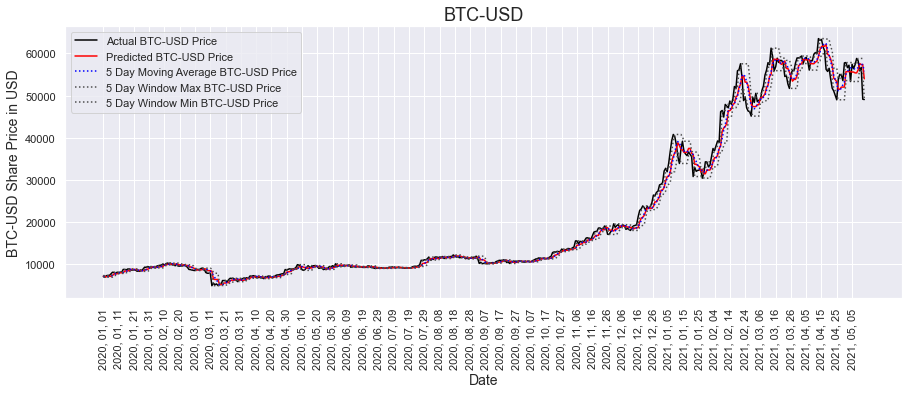

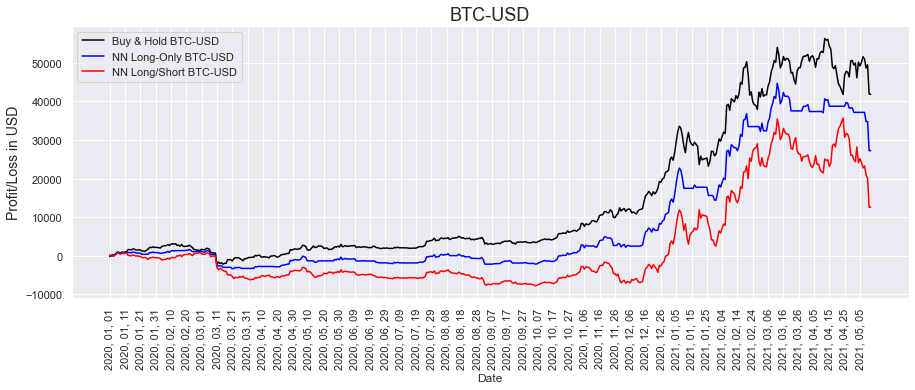

Long Only Strategy:  $27250
Long-Short Strategy: $12636
Buy & Hold Strategy: $41865


In [36]:
long_only, longshort, buyhold = trade(company = 'BTC-USD', market_symbol = '24/7', train_start = start, train_end = end,
                                      test_start = test_start, test_end = None, window_days = 5,
                                      act_fun = 'sigmoid', list_arch = [3, 6, 1], iters = 10000, lrate = 0.01)

print('Long Only Strategy:  $' + str(int(long_only)))
print('Long-Short Strategy: $' + str(int(longshort)))
print('Buy & Hold Strategy: $' + str(int(buyhold)))

On BTC our 30 day network performed well, but the 5 day network performs very poorly. The network's predictions lag critical market moves, and the trading strategy loses out heavily compared to its benchmark.

Activation function is:  sigmoid


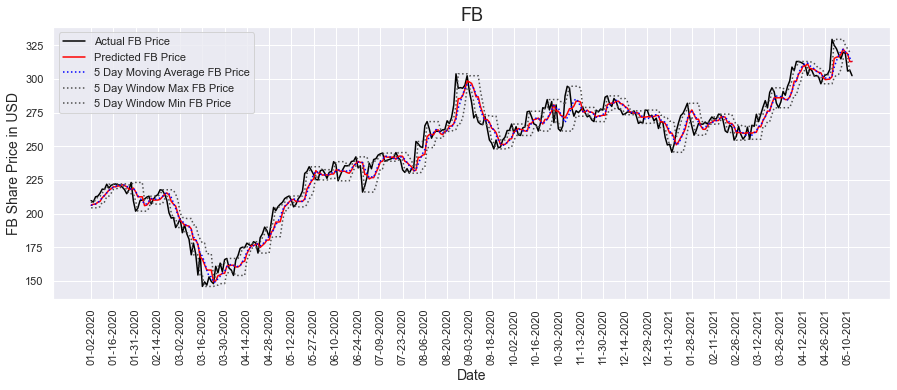

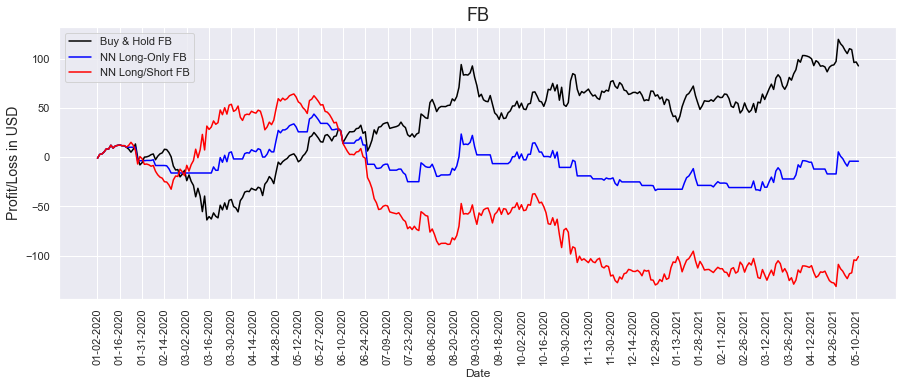

Long Only Strategy:  $-4
Long-Short Strategy: $-100
Buy & Hold Strategy: $92


In [37]:
long_only, longshort, buyhold = trade(company = 'FB', market_symbol = 'NYSE', train_start = start, train_end = end,
                                      test_start = test_start, test_end = None, window_days = 5,
                                      act_fun = 'sigmoid', list_arch = [3, 6, 1], iters = 10000, lrate = 0.01)

print('Long Only Strategy:  $' + str(int(long_only)))
print('Long-Short Strategy: $' + str(int(longshort)))
print('Buy & Hold Strategy: $' + str(int(buyhold)))

The short-window network is disastrous on FB as well, and its lagging property produces such poor 'predictions' that even the long-only strategy results in a net loss.

# Conclusion

In this project we implemented a 3-layer (1 hidden layer) neural network from scratch and analyzed its performance across a variety of parameters for the purpose of predicting stock prices. The network took inputs from trailing moving average stock prices as well as maximum and minimum achieved prices in a certain sliding window of time (60 days in our original specification), and output predictions for the price 1 day forward. The network was trained on 8 years of data from the start of 2012 to the start of 2020, and then tested on almost 1.5 years of data from the start of 2020 to the present (May 2021). The assets we chose to predict were the 4 tech stocks FB, AAPL, AMZN and MSFT, as well as the cryptocurrency BTC, with price data imported from Yahoo Finance.

We compared and contrasted 3 different neural net activation functions: sigmoid, hyperbolic tangent (tanh) and rectified linear unit (ReLU). We found that ReLU converged quickly but imprecisely, sigmoid converged slowly but more precisely, and tanh was in the middle on both properties. We compared and contrasted the effects of changing the number of backpropagation iterations and the learning rate of the network. We saw the effects of changing the sliding window length for our input parameters. We graphically displayed the results of our experiments. Finally, we created a small trading simulation based on our neural network over the span of our testing data and were able to achieve a successful outcome overall.

# References

https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7
    
https://www.samsonzhang.com/2020/11/24/understanding-the-math-behind-neural-networks-by-building-one-from-scratch-no-tf-keras-just-numpy
    
https://hmkcode.com/ai/backpropagation-step-by-step/

https://stackoverflow.com/questions/49604224/pulling-stock-information-using-pandas-datareader

https://finance.yahoo.com/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAMy0xuAhu1TWfqlImsEijBq8BjvPEb_toiwqzk9Fup2Uprtjq04Ehc5NlGniRhLlwbF2JgXq73OAF58ccVs7q_oDs-tTESi6B96F8nd4i0YYIW0co8iBURwoXlQRN2FBVqk8Qn09PtHa3dkgY3nbVUKaMidn77_MBmApXDlccLDo

https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe#:~:text=fit_transform()%20is%20used%20on,to%20scale%20our%20test%20data.

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

https://www.youtube.com/watch?v=ZzWaow1Rvho

# Contribution by Team Member

workdone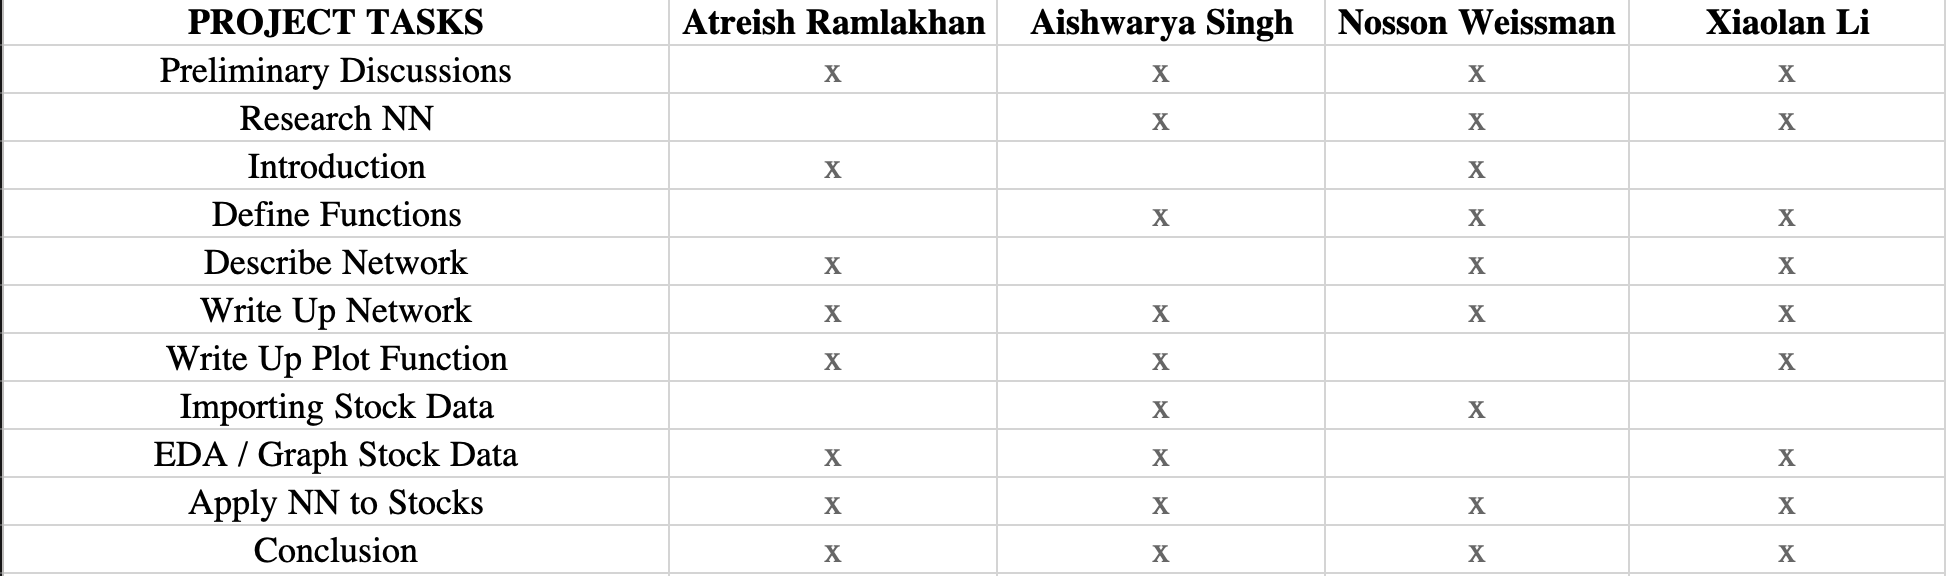